In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
TEST_PATH = "/homes/gws/mikeam/seattleflustudy/new_dataset/split-2020-02-10/test_minute_petastorm"
TRAIN_PATH = "/homes/gws/mikeam/seattleflustudy/new_dataset/split-2020-02-10/train_minute_petastorm"
EVAL_PATH = "/homes/gws/mikeam/seattleflustudy/new_dataset/split-2020-02-10/eval_minute_petastorm"


import numpy as np

from matplotlib import pyplot as plt

import os
os.chdir("/homes/gws/mikeam/seattleflustudy")
# os.environ["CUDA_VISIBLE_DEVICES"]=""
import pytorch_lightning as pl
from pytorch_lightning.loggers.wandb import WandbLogger

import torch

from petastorm import make_reader
from petastorm.pytorch import DataLoader as PetastormDataLoader

from src.models.models import CNNToTransformerEncoder
from src.models.tasks import get_task_with_name
from src.models.commands import validate_yaml_or_json

import seaborn as sns

/homes/gws/mikeam/miniconda3/envs/seattleflustudy/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
  "update your install command.", FutureWarning)


In [2]:
def get_test_model(path, task_config, ckpt_path, **extra_args):
    model = CNNToTransformerEncoder.load_from_checkpoint(ckpt_path,
                                                        strict=False,
                                                        **extra_args)
    task_config = validate_yaml_or_json(None,None,task_config)

    task =  get_task_with_name(task_config["task_name"])(dataset_args = task_config["dataset_args"],
                                                         activity_level="minute",
                                                         backend="petastorm",
                                                         test_path=path)
    trainer = pl.Trainer(gpus = 1,
                         accelerator="dp",
                         terminate_on_nan=True,
                         num_sanity_val_steps=0,
                         auto_select_gpus=True,
                         limit_train_batches=10)

    with PetastormDataLoader(make_reader(task.test_url,transform_spec=task.transform),
                                   batch_size=3*model.batch_size) as test_dataset:
        trainer.test(model,test_dataset)
    return model

In [3]:
BEST_FOCAL_MODEL_PATH="/homes/gws/mikeam/seattleflustudy/models/faithful-forest-1975-1.ckpt"
TASK = "/homes/gws/mikeam/seattleflustudy/src/data/task_configs/PredictFluPos.yaml"

In [4]:
def get_test_results_from_model(model):
    return pd.DataFrame(
        {
            "date": pd.to_datetime(np.concatenate(model.test_dates,axis=0)),
            "participant_id" : np.concatenate(model.test_participant_ids,axis=0),
            "pos_prob" :  torch.cat(model.test_probs, dim=0).cpu().numpy(),
            "label" : torch.cat(model.test_labels, dim=0).cpu().numpy()
        })

def run_data_on_model(data, task, model_path,**model_kwargs):
    model = get_test_model(data,
                          task,
                          model_path,
                          **model_kwargs)
    return get_test_results_from_model(model)

In [5]:

focal_test_results = run_data_on_model(TEST_PATH,TASK,BEST_FOCAL_MODEL_PATH,loss_fn="FocalLoss")

10/08/2021 17:02:38 - INFO - src.data.utils -   Reading lab_results_with_triggerdate...
10/08/2021 17:02:38 - INFO - src.data.utils -   Reading lab_results_with_triggerdate...
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test/loss': 0.019857630133628845,
 'test/loss_epoch': 0.006691687740385532,
 'test/pr_auc': 0.0004913801742685408,
 'test/roc_auc': 0.5654155015945435}
--------------------------------------------------------------------------------


In [6]:
focal_test_results.groupby("label").describe()

pos_prob                                                              \
          count      mean       std       min       25%       50%       75%   
label                                                                         
0      120817.0  0.006355  0.008229  0.000014  0.003684  0.005462  0.007906   
1          48.0  0.006920  0.003584  0.000594  0.004172  0.006680  0.009066   

                 
            max  
label            
0      1.000000  
1      0.013664

In [7]:
focal_test_results.groupby("label").quantile([0.9, 0.95, 0.99, 0.999])

pos_prob
label                
0     0.900  0.011179
      0.950  0.014239
      0.990  0.018788
      0.999  0.028341
1     0.900  0.012510
      0.950  0.013192
      0.990  0.013484
      0.999  0.013646

It's really weird that there's such a long tailed distribution on the test results... 

Text(0.5, 1.0, 'Distribution of Positive Probability on Test Set - Focal Loss')

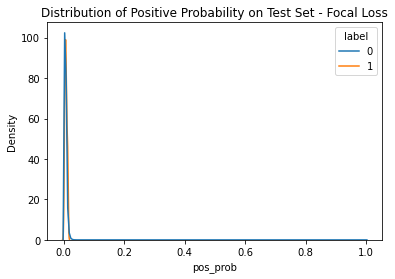

In [8]:
sns.kdeplot(data = focal_test_results,
            x = "pos_prob",     
            hue = "label",
            common_norm=False)
plt.title("Distribution of Positive Probability on Test Set - Focal Loss")

Text(0.5, 1.0, 'Distribution of Positive Probability on Test Set - Focal Loss')

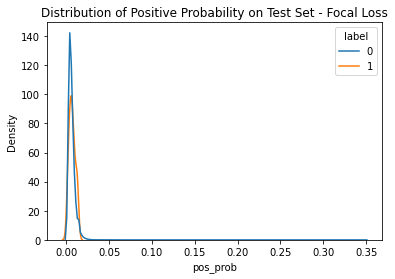

In [9]:
sns.kdeplot(data = focal_test_results[focal_test_results["pos_prob"]<0.75],
            x = "pos_prob",     
            hue = "label",
            common_norm=False)
plt.title("Distribution of Positive Probability on Test Set - Focal Loss")

<AxesSubplot:xlabel='pos_prob', ylabel='Density'>

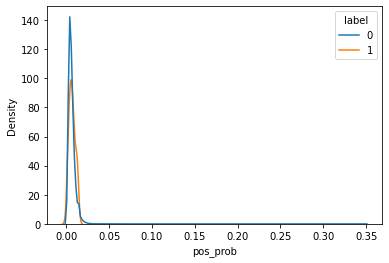

In [10]:
sns.kdeplot(data = focal_test_results[focal_test_results["pos_prob"]<0.75],
            x = "pos_prob",     
            hue = "label",
            common_norm=False)

TODO: Is is possible that the examples towards the very end are what's contributing to the loss?

Text(0.5, 1.0, 'All Test Samples - Focal Loss')

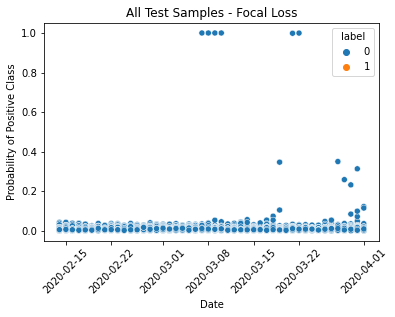

In [11]:
sns.scatterplot(x=focal_test_results["date"],y=focal_test_results["pos_prob"],
                hue=focal_test_results["label"])
plt.xticks(rotation=45)
plt.ylabel("Probability of Positive Class")
plt.xlabel("Date")
plt.title("All Test Samples - Focal Loss")

What's going on here? Why are there four days (right next to each other?) where the model is confident and wrong?

In [12]:
focal_test_results[focal_test_results["pos_prob"]>0.9]

,date,participant_id,pos_prob,label
37922,2020-03-08 23:59:59.999,da4a1a2114cab7fe17b67d46c484e0f0,1.000000,0
42060,2020-03-09 23:59:59.999,da4a1a2114cab7fe17b67d46c484e0f0,1.000000,0
43242,2020-03-07 23:59:59.999,da4a1a2114cab7fe17b67d46c484e0f0,1.000000,0
48110,2020-03-20 23:59:59.999,e68b97d609ece6286a1f6a2e482bb3cf,0.998669,0
66847,2020-03-06 23:59:59.999,da4a1a2114cab7fe17b67d46c484e0f0,1.000000,0
94723,2020-03-21 23:59:59.999,e68b97d609ece6286a1f6a2e482bb3cf,0.999596,0


Text(0.5, 1.0, 'True Positive Test Samples - Focal Loss')

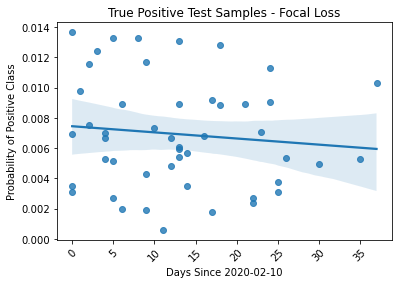

In [13]:
focal_pos_test_labels = focal_test_results[focal_test_results["label"].astype(bool)]
sns.regplot(x=(focal_pos_test_labels["date"] - min(focal_pos_test_labels["date"])).dt.days,
            y=focal_pos_test_labels["pos_prob"])
plt.xticks(rotation=45)
plt.ylabel("Probability of Positive Class")
plt.xlabel("Days Since 2020-02-10")
plt.title("True Positive Test Samples - Focal Loss")

In [14]:
focal_train_results =  run_data_on_model(TRAIN_PATH,TASK,BEST_FOCAL_MODEL_PATH,loss_fn="FocalLoss")

10/08/2021 17:04:22 - INFO - src.data.utils -   Reading lab_results_with_triggerdate...
10/08/2021 17:04:23 - INFO - src.data.utils -   Reading lab_results_with_triggerdate...
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test/loss': 0.009449108503758907,
 'test/loss_epoch': 0.0071250940673053265,
 'test/pr_auc': 0.0007454889046060935,
 'test/roc_auc': 0.5644346475601196}
--------------------------------------------------------------------------------


<AxesSubplot:xlabel='pos_prob', ylabel='Density'>

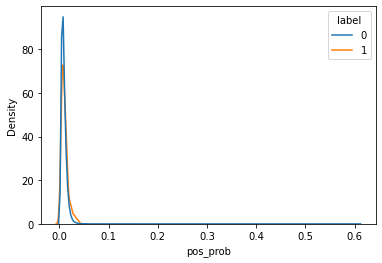

In [15]:
sns.kdeplot(data = focal_train_results,
            x = "pos_prob",     
            hue = "label",
            common_norm=False)

Okay, but this is a pretty early epoch - what do things look like with a model that's been trained for even longer?

In [16]:
epoch_100_small_model_focal_train_results =  run_data_on_model(
                            TRAIN_PATH,
                            TASK,
                            "/homes/gws/mikeam/seattleflustudy/wandb/run-20211007_151647-1q5sacky/files/flu/1q5sacky/checkpoints/epoch=99-.ckpt",
                            loss_fn="FocalLoss")

10/08/2021 17:06:33 - INFO - src.data.utils -   Reading lab_results_with_triggerdate...
10/08/2021 17:06:33 - INFO - src.data.utils -   Reading lab_results_with_triggerdate...
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test/loss': 0.005566793028265238,
 'test/loss_epoch': 0.00392639497295022,
 'test/pr_auc': 0.0012381098348062797,
 'test/roc_auc': 0.7051527500152588}
--------------------------------------------------------------------------------


Text(0.5, 1.0, 'Training Data - 100 epoch on Small Model - Focal Loss\nTransformer Input: 39x8\nClassifier Input: 64')

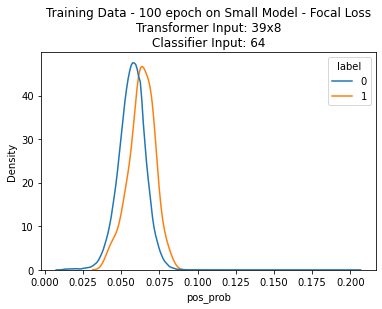

In [17]:
sns.kdeplot(data = epoch_100_small_model_focal_train_results,
            x = "pos_prob",     
            hue = "label",
            common_norm=False)
plt.title("Training Data - 100 epoch on Small Model - Focal Loss"
         "\nTransformer Input: 39x8"
         "\nClassifier Input: 64")

What about one of the models that didn't have the smaller internal dimension? 

In [18]:
epoch_60__focal_train_results =  run_data_on_model(
                            TRAIN_PATH,
                            TASK,
                            "/homes/gws/mikeam/seattleflustudy/models/2irbj1hl-59.ckpt",
                            loss_fn="FocalLoss")

10/08/2021 17:08:49 - INFO - src.data.utils -   Reading lab_results_with_triggerdate...
10/08/2021 17:08:49 - INFO - src.data.utils -   Reading lab_results_with_triggerdate...
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test/loss': 0.005416063591837883,
 'test/loss_epoch': 0.002003465546295047,
 'test/pr_auc': 0.08948527631297455,
 'test/roc_auc': 0.9717898964881897}
--------------------------------------------------------------------------------


Text(0.5, 1.0, 'Training Data - 59 epoch on Larger Model - Focal Loss\nTransformer Input: 64x59\nClassifier Input: 4096')

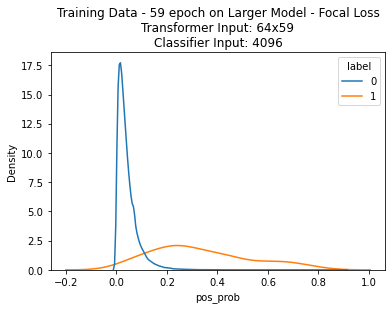

In [19]:
sns.kdeplot(data = epoch_60__focal_train_results,
            x = "pos_prob",     
            hue = "label",
            common_norm=False)
plt.title("Training Data - 59 epoch on Larger Model - Focal Loss"
         "\nTransformer Input: 64x59"
         "\nClassifier Input: 4096")

Small model, trained for longer:

In [20]:
epoch_60_small_focal_train_results =  run_data_on_model(
                            TRAIN_PATH,
                            TASK,
                            "/homes/gws/mikeam/seattleflustudy/wandb/run-20211008_095440-uop5hkiy/files/flu/uop5hkiy/checkpoints/epoch=59-.ckpt",
                            loss_fn="FocalLoss")

10/08/2021 17:11:01 - INFO - src.data.utils -   Reading lab_results_with_triggerdate...
10/08/2021 17:11:01 - INFO - src.data.utils -   Reading lab_results_with_triggerdate...
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test/loss': 0.0025990556459873915,
 'test/loss_epoch': 0.00240714056417346,
 'test/pr_auc': 0.4353190271701471,
 'test/roc_auc': 0.9883517622947693}
--------------------------------------------------------------------------------


Text(0.5, 1.0, 'Training Data - 100 epoch on Small Model - Focal Loss\nTransformer Input: 39x8\nClassifier Input: 64')

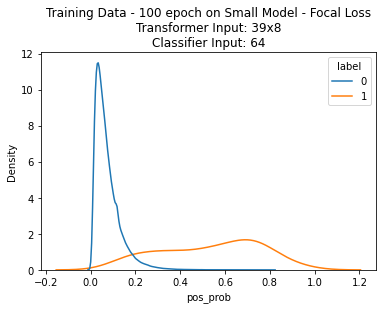

In [21]:
sns.kdeplot(data = epoch_60_small_focal_train_results,
            x = "pos_prob",     
            hue = "label",
            common_norm=False)
plt.title("Training Data - 100 epoch on Small Model - Focal Loss"
         "\nTransformer Input: 39x8"
         "\nClassifier Input: 64")

In [23]:
epoch_60_small_focal_test_results = run_data_on_model(
                            TEST_PATH,
                            TASK,
                            "/homes/gws/mikeam/seattleflustudy/wandb/run-20211008_095440-uop5hkiy/files/flu/uop5hkiy/checkpoints/epoch=59-.ckpt",
                            loss_fn="FocalLoss")

10/08/2021 17:18:32 - INFO - src.data.utils -   Reading lab_results_with_triggerdate...
10/08/2021 17:18:32 - INFO - src.data.utils -   Reading lab_results_with_triggerdate...
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test/loss': 0.0013637563679367304,
 'test/loss_epoch': 0.0044225407764315605,
 'test/pr_auc': 0.0005715808853517148,
 'test/roc_auc': 0.5875334739685059}
--------------------------------------------------------------------------------


Text(0.5, 1.0, 'Training Data - 60 epoch on Small Model - Focal Loss\nTransformer Input: 39x8\nClassifier Input: 64')

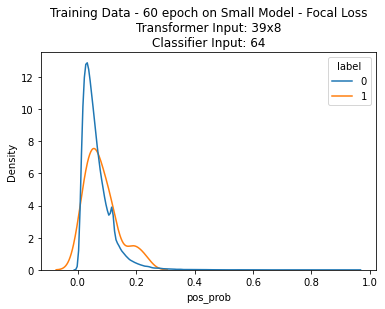

In [24]:
sns.kdeplot(data = epoch_60_small_focal_test_results,
            x = "pos_prob",     
            hue = "label",
            common_norm=False)
plt.title("Training Data - 60 epoch on Small Model - Focal Loss"
         "\nTransformer Input: 39x8"
         "\nClassifier Input: 64")